# Costa Rica - Poverty Prediction Assignment

This is a supervised multi-class classification machine learning problem:


* Supervised: provided with the labels for the training data
* Multi-class classification: Labels are discrete values with 4 classes

## Objective

The end objective is a machine learning model that can predict the poverty level of a household. However, before we get carried away with modeling, it's important to understand the problem and data. Also, we want to evaluate numerous models before choosing one as the "best" and after building a model, we want to investigate the predictions. Our approach is therefore as follows:

1.   Understand the problem
2.   Exploratory Data Analysis
3.   Feature engineering to create a dataset for machine learning
4.   Compare several baseline machine learning models
5.   Try more complex machine learning models
6.   Optimize the selected model
7.   Investigate model predictions in context of problem
8.   Draw conclusions and lay out next steps

## Pre-Requisites
    Importing Necessary Modules
    Reading the Data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import  OneHotEncoder as ohe
from sklearn.preprocessing import StandardScaler as ss
from sklearn.compose import ColumnTransformer as ct

In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, recall_score

In [4]:
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [5]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
train.shape
test.shape
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,...,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,...,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,...,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


Lets analyze the integer values  and find out which one has more no. of unique values

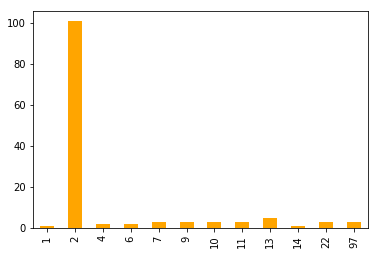

In [7]:
train.select_dtypes(np.int64).nunique().value_counts().sort_index().plot.bar(color='orange')

From the above graph, we observe that boolean values (0 or 1) have more count compare to others.

Lets investigate the float columns, since it is continous lets see how it is distributed across the data

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


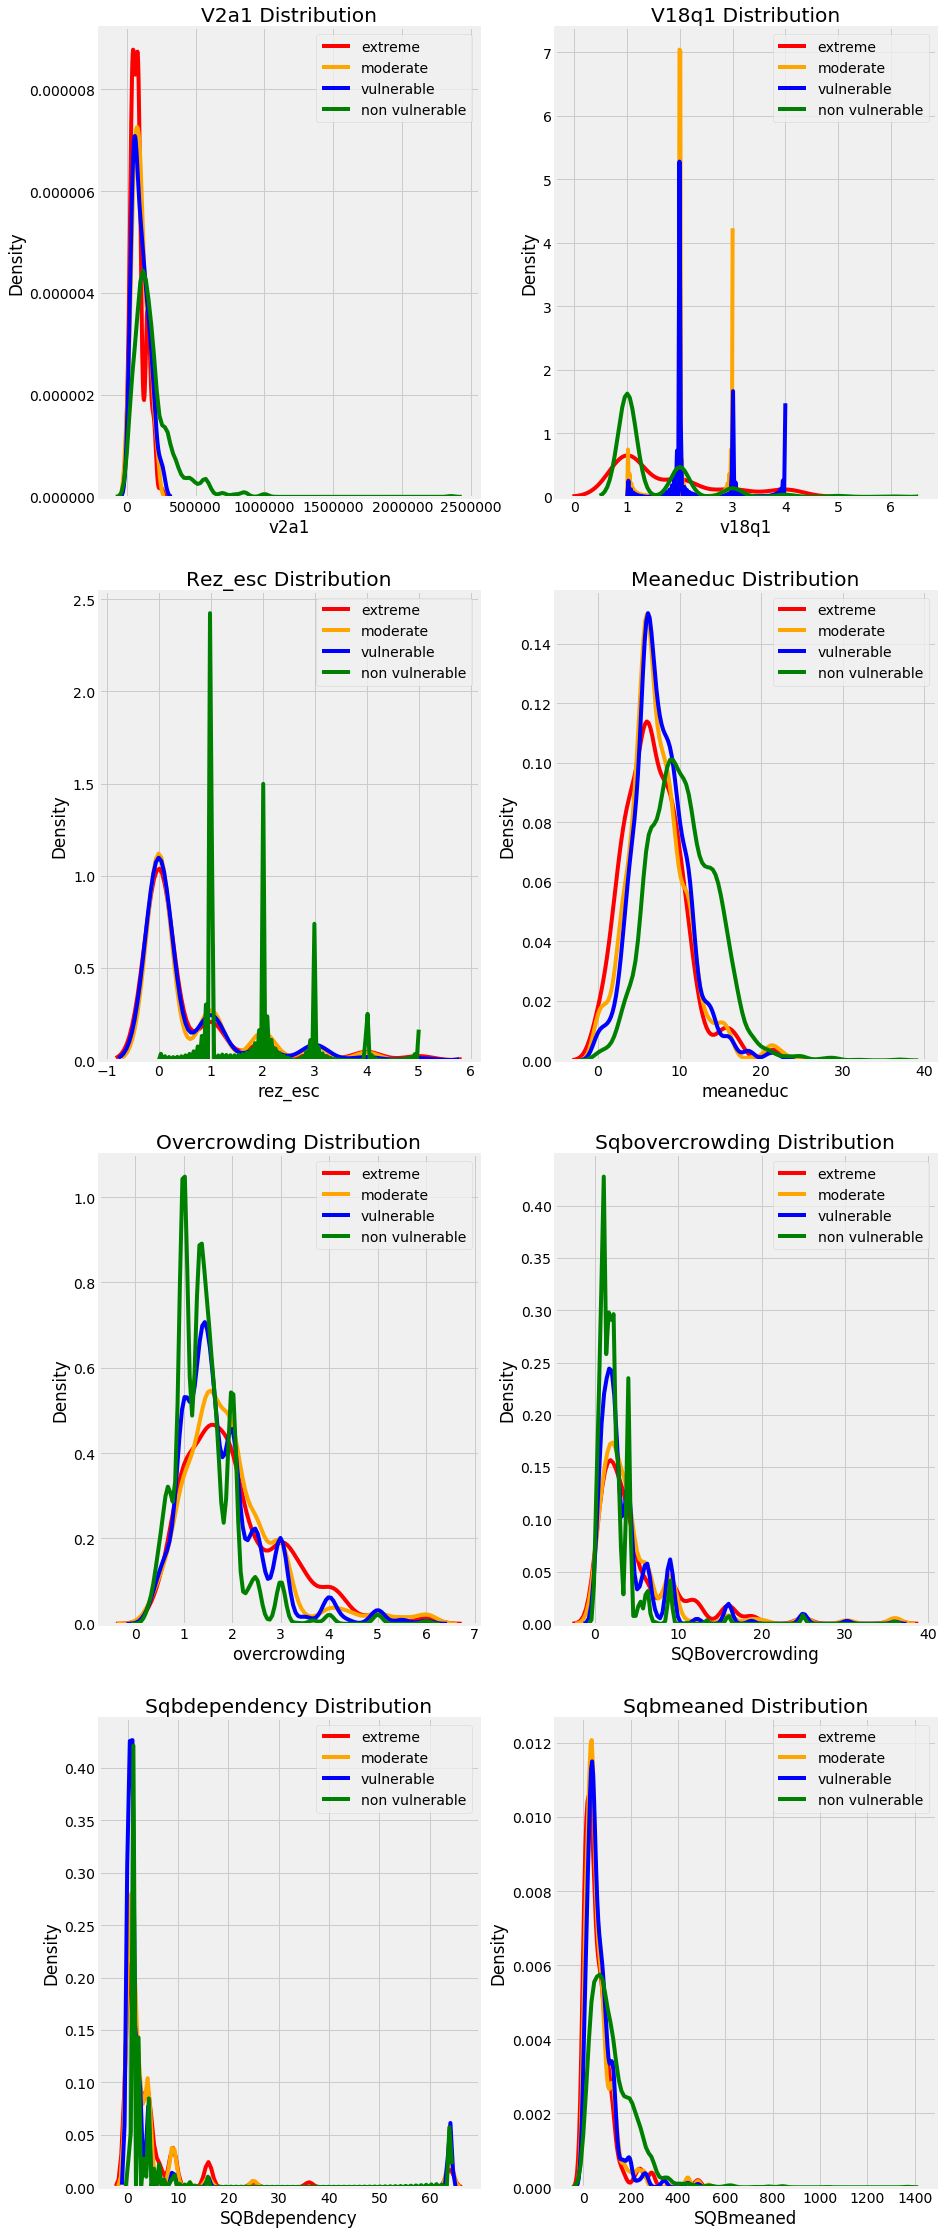

In [8]:
from collections import OrderedDict

plt.figure(figsize = (15,16))
plt.style.use('fivethirtyeight')

# Color mapping
colors = OrderedDict({1: 'red', 2: 'orange', 3: 'blue', 4: 'green'})
poverty_mapping = OrderedDict({1: 'extreme', 2: 'moderate', 3: 'vulnerable', 4: 'non vulnerable'})

# Iterate through the float columns
for i, col in enumerate(train.select_dtypes('float')):
    ax = plt.subplot(4, 2, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)


In [9]:
# object columns

train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


As the object types having mixed values i.e., alphanumeric, it should be converted into integer values before proceeding with any machine model. We are concentrating only three features
1. dependency
2. edjefe
3. edjefa

Make the boolean values (Yes & No) with 1 & 0 respectively in both train and test data

In [10]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)

train[['dependency', 'edjefa', 'edjefe']].describe()

,dependency,edjefa,edjefe
count,9557.000000,9557.000000,9557.000000
mean,1.149550,2.896830,5.096788
std,1.605993,4.612056,5.246513
min,0.000000,0.000000,0.000000
25%,0.333333,0.000000,0.000000
50%,0.666667,0.000000,6.000000
75%,1.333333,6.000000,9.000000
max,8.000000,21.000000,21.000000


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


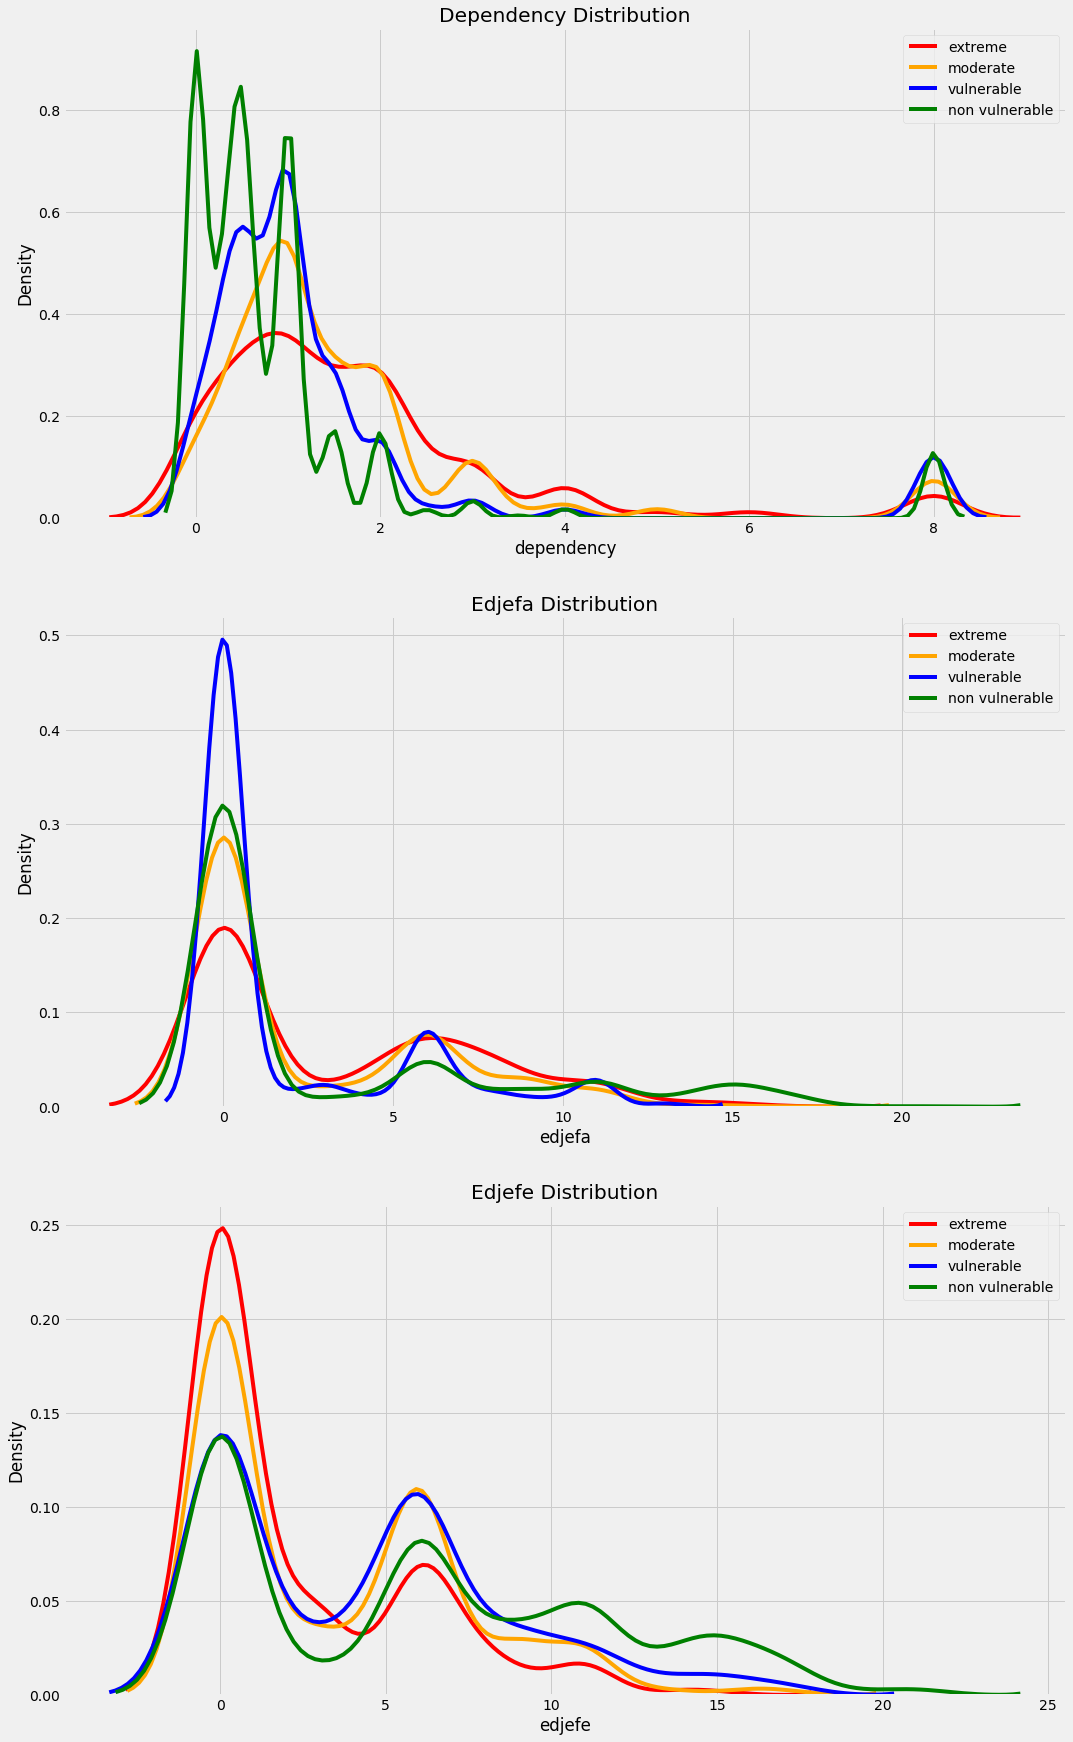

In [11]:
# Plot the graph for distribution after replacing integer values

plt.figure(figsize = (16, 12))

# Iterate through the float columns
for i, col in enumerate(['dependency', 'edjefa', 'edjefe']):
    ax = plt.subplot(3, 1, i + 1)
    # Iterate through the poverty levels
    for poverty_level, color in colors.items():
        # Plot each poverty level as a separate line
        sns.kdeplot(train.loc[train['Target'] == poverty_level, col].dropna(), 
                    ax = ax, color = color, label = poverty_mapping[poverty_level])
        
    plt.title(f'{col.capitalize()} Distribution'); plt.xlabel(f'{col}'); plt.ylabel('Density')

plt.subplots_adjust(top = 2)

Now we have corrected all the necessary values of features into numbers, which can be further used in the machine learning model

Concat both train and test data for easy manipulation and to avoid any discrepancies while doing featuring engineering

In [12]:
test['Target'] = np.nan
data = train.append(test, ignore_index=True)

In [13]:
data.shape

(33413, 143)

## Correcting Errors - Missing Values

Finding out missing values and get corrected

In [14]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(10).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077
meaneduc,36,0.001077
hogar_adul,0,0.000000
parentesco10,0,0.000000
parentesco11,0,0.000000
parentesco12,0,0.000000
